# Introduction

This project analyzes the Hotel Booking Demand dataset published on [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data), which contains booking information from a city hotel and a resort hotel. The dataset provides real-world hospitality data that will be used to explore customer booking patterns and business trends. Through this analysis, we aim to gain insights into hotel operations and apply statistical techniques learned in class.

**Data Dictionary** - https://www.datacamp.com/datalab/datasets/dataset-r-hotel-booking-demand#data-dictionary

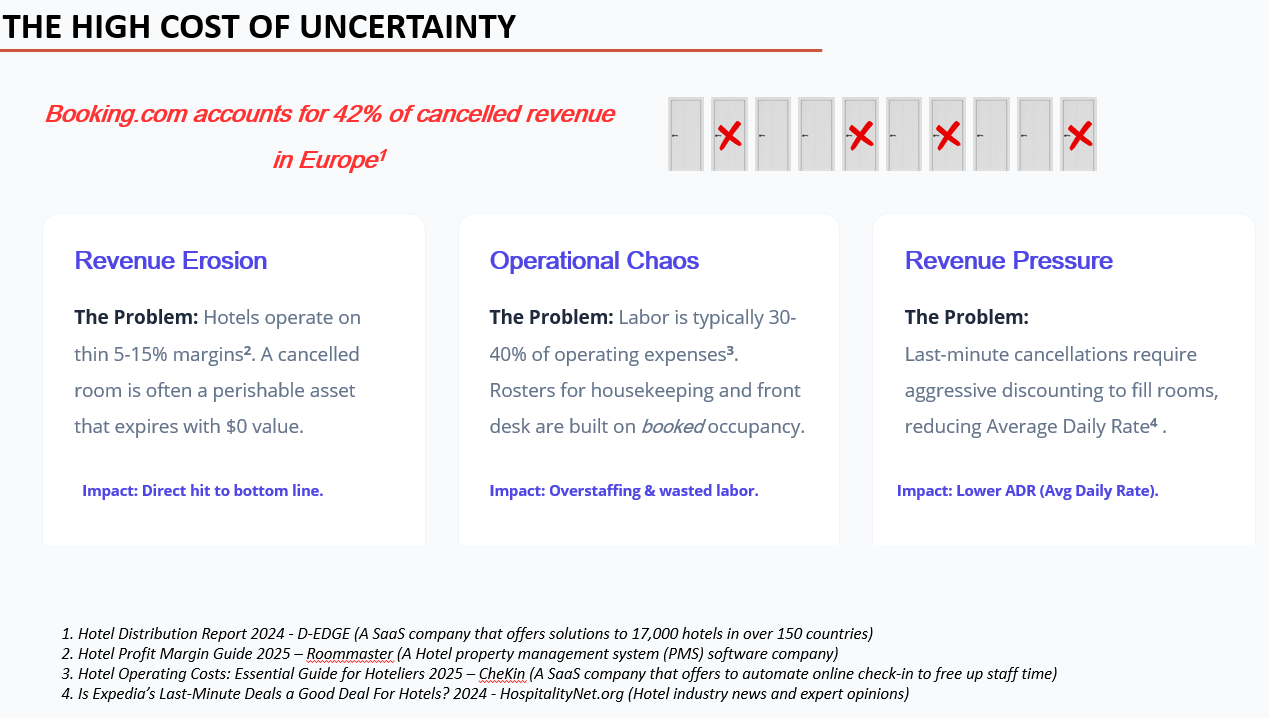

Step 1 - Install packages and load libraries

In [ ]:
#Install required packages

install.packages("Hmisc")
install.packages("ggplot2")
install.packages("rpart")
install.packages("rpart.plot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘gridExtra’, ‘htmlTable’, ‘colorspace’, ‘Formula’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#Load and attach installed packages
library(readxl)
library(Hmisc)
library(ggplot2)
library(dplyr)


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘dplyr’


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Data Exploration

**Step 1 - Load dataset into R dataframe called "bookings"**

In [133]:
# Read the file into R
bookings <- read.csv("/content/hotel_bookings.csv")
#head(bookings)

In [134]:
#Count rows and columns
nrow(bookings);ncol(bookings)

[1] 119390

[1] 32

**Step 2 - Filter to remove Resort hotels in dataframe**

In [135]:
bookings <-bookings[bookings$hotel =="City Hotel",]

In [136]:
#Drop Hotel column as it is now filtered to City Hotels
bookings <- select(bookings, -hotel)

In [137]:
#Count rows and columns
nrow(bookings);ncol(bookings)

[1] 79330

[1] 31

In [138]:
# Keep only rows where deposit_type is NOT "Refundable" - 20 Rows of 79,330
bookings <- bookings[bookings$deposit_type != "Refundable", ]

In [139]:
#Count rows and columns
nrow(bookings);ncol(bookings)

[1] 79310

[1] 31

In [140]:
# Keep only rows where market_segment is NOT "Undefined" - 2 Rows of 79,330
bookings <- bookings[bookings$market_segment != "Undefined", ]

# Keep only rows where distribution_channel is NOT "Undefined" - 4 Rows of 79,330
bookings <- bookings[bookings$distribution_channel != "Undefined", ]

In [141]:
#Count rows and columns
nrow(bookings);ncol(bookings)

[1] 79306

[1] 31

**Step 3 - Convert Is_Cancelled to Factor column**

In [142]:
#Count BEFORE processing

table(bookings$is_canceled)


    0     1 
46222 33084 

In [143]:
bookings$is_canceled <- factor(bookings$is_canceled,levels=c(0,1),labels = c("Not cancelled","Cancelled"))

In [144]:
#Count AFTER processing

table(bookings$is_canceled)


Not cancelled     Cancelled 
        46222         33084 

In [145]:
str(bookings)

'data.frame':	79306 obs. of  31 variables:
 $ is_canceled                   : Factor w/ 2 levels "Not cancelled",..: 1 2 2 2 2 2 1 2 2 2 ...
 $ lead_time                     : int  6 88 65 92 100 79 3 63 62 62 ...
 $ arrival_date_year             : int  2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 ...
 $ arrival_date_month            : chr  "July" "July" "July" "July" ...
 $ arrival_date_week_number      : int  27 27 27 27 27 27 27 27 27 27 ...
 $ arrival_date_day_of_month     : int  1 1 1 1 2 2 2 2 2 2 ...
 $ stays_in_weekend_nights       : int  0 0 0 2 0 0 0 1 2 2 ...
 $ stays_in_week_nights          : int  2 4 4 4 2 3 3 3 3 3 ...
 $ adults                        : int  1 2 1 2 2 2 1 1 2 2 ...
 $ children                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ babies                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ meal                          : chr  "HB" "BB" "BB" "BB" ...
 $ country                       : chr  "PRT" "PRT" "PRT" "PRT" ...
 $ market_segment             

**Step 4 - Remove date columns and treat as cross sectional data (not panel data)**

In [146]:
#Remove date columns and treat as cross sectional data (not panel data)
bookings <- select(bookings, -arrival_date_year, -arrival_date_month,
                   -arrival_date_week_number, -arrival_date_day_of_month, -reservation_status_date)

In [147]:
#Count rows and columns
nrow(bookings);ncol(bookings)

[1] 79306

[1] 26

**Step 5 - Check for Missing values in columns**

In [148]:
# Print missing value counts only for columns with missing values
for (col in names(bookings)) {
  missing_count <- sum(is.na(bookings[[col]]))
  if (missing_count > 0) {
    cat(col, ": ", missing_count, "\n", sep = "")
  }
}

**No rows have missing values**

**Step 6 - Removing Outliers in relevant columns**

In [149]:
# Create vector of Numeric column names
numeric_cols <- names(bookings)[sapply(bookings, is.numeric)]; numeric_cols

[1] "lead_time"                      "stays_in_weekend_nights"       
 [3] "stays_in_week_nights"           "adults"                        
 [5] "children"                       "babies"                        
 [7] "is_repeated_guest"              "previous_cancellations"        
 [9] "previous_bookings_not_canceled" "booking_changes"               
[11] "days_in_waiting_list"           "adr"                           
[13] "required_car_parking_spaces"    "total_of_special_requests"

In [150]:
# Print outlier counts for all Numeric columns
for (col in numeric_cols) {
  Q1 <- quantile(bookings[[col]], 0.25, na.rm = TRUE)
  Q3 <- quantile(bookings[[col]], 0.75, na.rm = TRUE)
  IQR <- Q3 - Q1
  outliers <- bookings[[col]] < (Q1 - 1.5 * IQR) | bookings[[col]] > (Q3 + 1.5 * IQR)
  outliers[is.na(outliers)] <- FALSE
  cat(col, ": ", sum(outliers), "\n", sep = "")
}

lead_time: 2576
stays_in_weekend_nights: 82
stays_in_week_nights: 716
adults: 21067
children: 5105
babies: 369
is_repeated_guest: 2032
previous_cancellations: 5389
previous_bookings_not_canceled: 1588
booking_changes: 10264
days_in_waiting_list: 3442
adr: 3386
required_car_parking_spaces: 1925
total_of_special_requests: 1810


`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


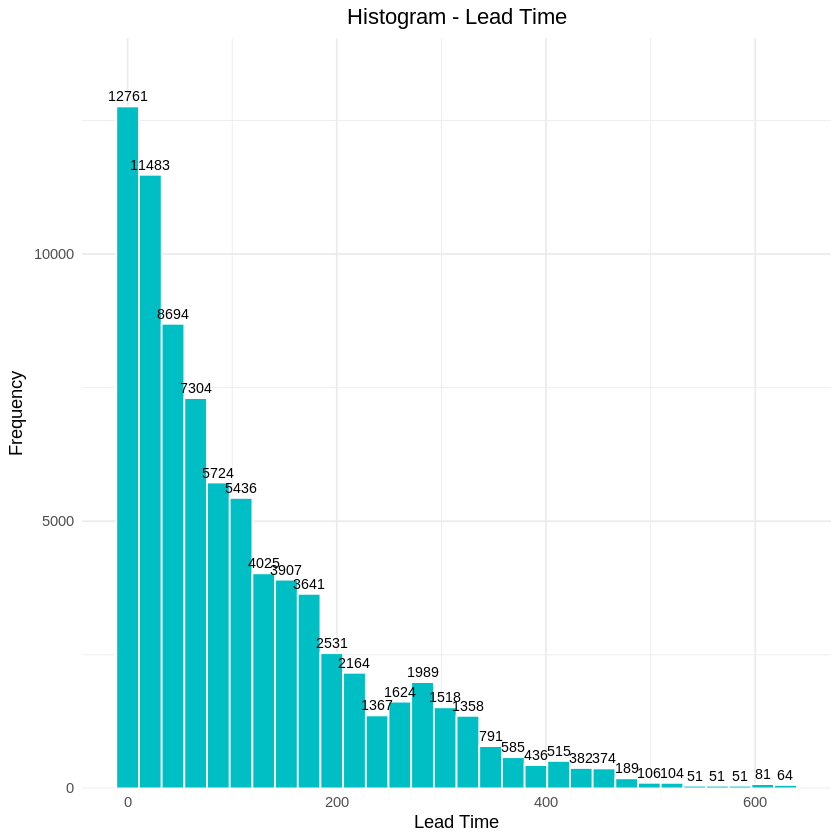

In [151]:
ggplot(data = bookings, aes(x = lead_time)) +
  geom_histogram(
    fill = "#00BFC4",
    color = "white",
    bins = 30
  ) +
  geom_text(
    aes(label = after_stat(count)), # Label with the calculated count
    stat = "bin",                  # Use the same bin statistics as geom_histogram
    vjust = -0.5,                  # Position the label slightly above the bar
    color = "black",
    size = 3
  ) +
  labs(
    title = "Histogram - Lead Time",
    x = "Lead Time",
    y = "Frequency"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1))) # Ensure labels fit

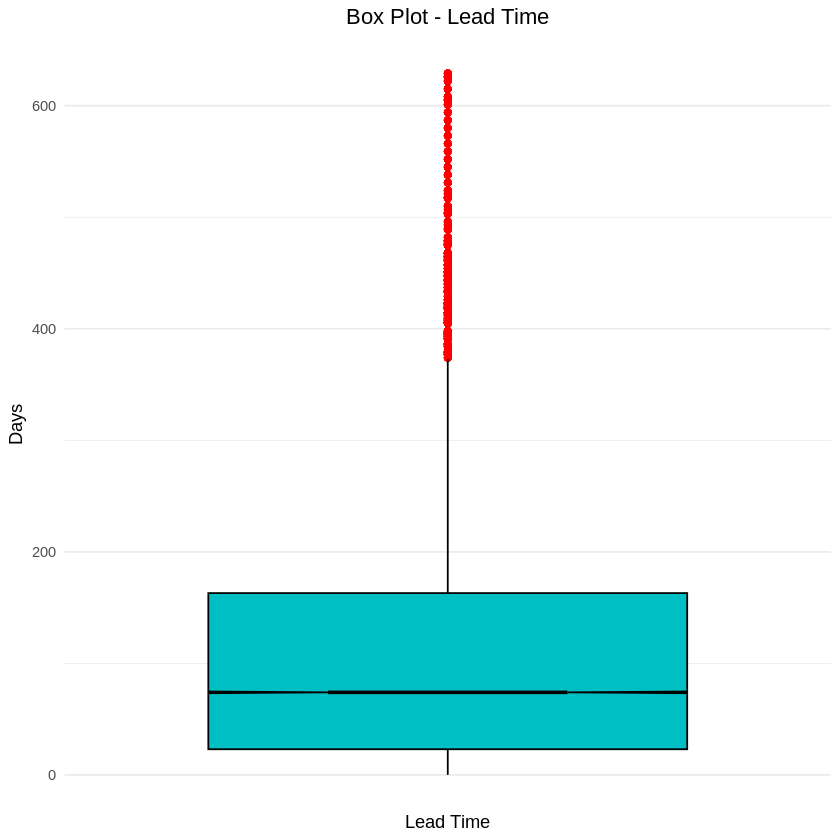

In [152]:
ggplot(data = bookings, aes(x = factor(1), y = lead_time)) +
  geom_boxplot(
    notch = TRUE,          # Enables the notch feature
    fill = "#00BFC4",      # Sets the fill color of the box
    color = "black",       # Sets the border color of the box/whiskers (optional)
    outlier.color = "red"  # Sets the color for outlier points (optional)
  ) +
  labs(
    title = "Box Plot - Lead Time", # Main title
    x = "Lead Time",               # X-axis label (xlab)
    y = "Days"          # Y-axis label (ylab)
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) + # Centers the title
  scale_x_discrete(labels = NULL, breaks = NULL)  # Hides the default '1' on the x-axis

In [153]:
summary(bookings$lead_time)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    23.0    74.0   109.7   163.0   629.0 

In [154]:
#Count rows and columns
nrow(bookings);ncol(bookings)

[1] 79306

[1] 26

In [155]:
#Remove outliers in columns - Lead Time
booking.df <- bookings

columns_to_remove <- c("lead_time")

for (col in columns_to_remove) {
  Q1 <- quantile(booking.df[[col]], 0.25, na.rm = TRUE)
  Q3 <- quantile(booking.df[[col]], 0.75, na.rm = TRUE)
  IQR <- Q3 - Q1
  outliers <- booking.df[[col]] < (Q1 - 1.5 * IQR) | booking.df[[col]] > (Q3 + 1.5 * IQR)
  booking.df <- booking.df[!outliers, ]
}

bookings <- booking.df

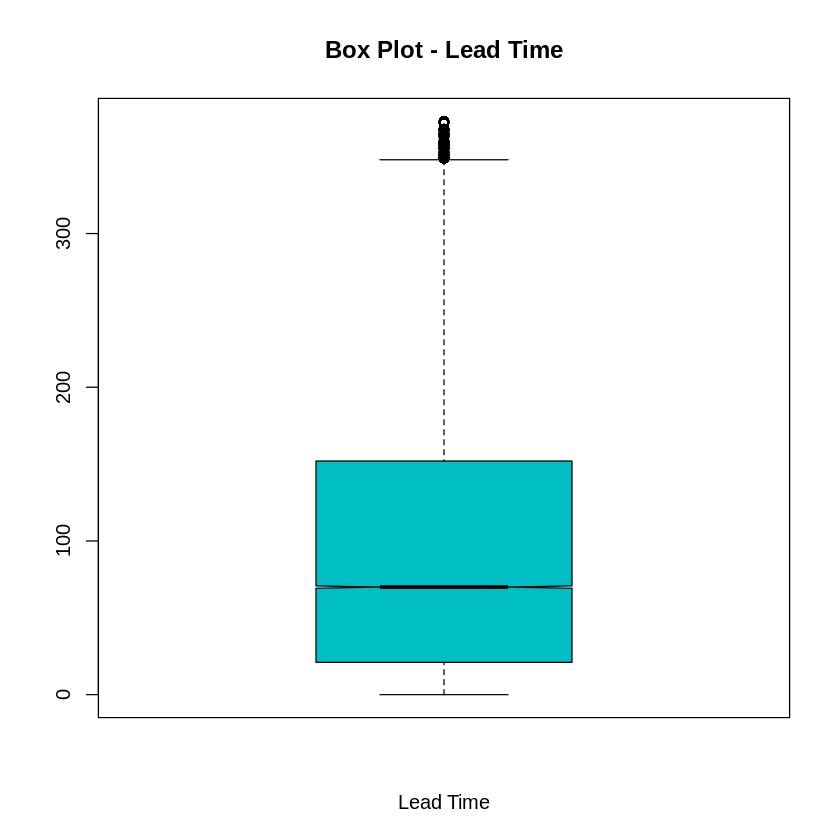

In [156]:
boxplot(bookings$lead_time, main="Box Plot - Lead Time",notch=TRUE, xlab="Lead Time", col="#00BFC4")

In [157]:
#Count rows and columns
nrow(bookings);ncol(bookings)

[1] 76730

[1] 26

In [158]:
# Define explicit bin breaks
bin_breaks <- c(0, 30, 60, 90, 180, 240, Inf)

# Set custom labels for each bin
bin_labels <- c("L30", "L60", "L90", "L180", "L240", "L240+")

# Create a binned factor for lead_time
bookings$lead_time_bin <- cut(
  bookings$lead_time,
  breaks = bin_breaks,
  labels = bin_labels,
  include.lowest = TRUE,
  right = FALSE
)


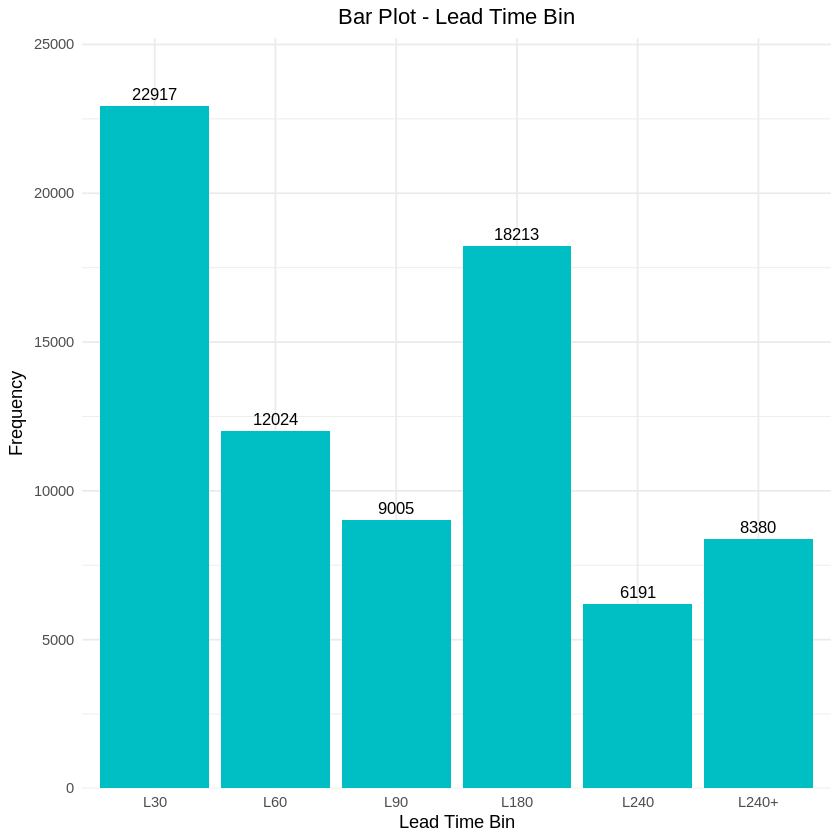

In [159]:
# Create the bar plot with count labels and centered title
ggplot(data = bookings, aes(x = lead_time_bin)) +
  geom_bar(fill = "#00BFC4") +
  geom_text(
    aes(label = after_stat(count)),
    stat = "count",
    vjust = -0.5,
    color = "black",
    size = 3.5
  ) +
  labs(
    title = "Bar Plot - Lead Time Bin",
    x = "Lead Time Bin",
    y = "Frequency"
  ) +
  theme_minimal() +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1))) +
  theme(plot.title = element_text(hjust = 0.5)) # This centers the title

**Step 7 - Add new columns for key catagorical columns**


In [160]:
#Agent
nrow(filter(bookings, agent == "NULL"))

[1] 8125

In [161]:
#Booked by Agent
bookings$booked_by_agent <- factor(ifelse(bookings$agent == "NULL", "No", "Yes"), levels = c("No", "Yes"))

In [162]:
nrow(filter(bookings, booked_by_agent == "No"))

[1] 8125

In [163]:
#Previous Cancellation
sum(bookings$previous_cancellations == 0)

[1] 71514

In [164]:
bookings$prior_bookings_cancelled <- factor(ifelse(bookings$previous_cancellations == 0, "No", "Yes"))

In [165]:
sum(bookings$prior_bookings_cancelled == "No")

[1] 71514

In [166]:
#Previous booking not cancelled
sum(bookings$previous_bookings_not_canceled == 0)

[1] 75143

In [167]:
bookings$prior_bookings_not_cancelled <- factor(ifelse(bookings$previous_bookings_not_canceled == 0, "No", "Yes"))

In [168]:
sum(bookings$prior_bookings_not_cancelled == "No")

[1] 75143

In [169]:
#Weekend Stays
sum(bookings$stays_in_weekend_nights != 0)

[1] 40652

In [170]:
bookings$includes_weekend <- factor(ifelse(bookings$stays_in_weekend_nights == 0, "No", "Yes"))

In [171]:
sum(bookings$includes_weekend == "Yes")

[1] 40652

In [172]:
#Weeknight Stays
sum(bookings$stays_in_week_nights != 0)

[1] 71912

In [173]:
bookings$includes_weekdays <- factor(ifelse(bookings$stays_in_week_nights == 0, "No", "Yes"))

In [174]:
sum(bookings$includes_weekdays == "Yes")

[1] 71912

In [175]:
#Booking changes
sum(bookings$booking_changes != 0)

[1] 10020

In [176]:
bookings$changes_to_booking <- factor(ifelse(bookings$booking_changes== 0, "No", "Yes"))

In [177]:
sum(bookings$changes_to_booking != "No")

[1] 10020

In [178]:
#Deposit paid
sum(bookings$deposit_type == "Non Refund")

[1] 11236

In [179]:
bookings$deposit_commitment <- factor(ifelse(bookings$deposit_type == "Non Refund", "Yes", "No"))

In [180]:
sum(bookings$deposit_commitment == "Yes")

[1] 11236

In [181]:
#Market Segment
table(bookings$market_segment)


     Aviation Complementary     Corporate        Direct        Groups 
          237           541          2982          6090         12315 
Offline TA/TO     Online TA 
        15835         38730 

In [182]:
bookings$market_segment_Offline_Ta_To <- factor(ifelse(bookings$market_segment == "Offline TA/TO", 1, 0))
bookings$market_segment_Online_TaTo <- factor(ifelse(bookings$market_segment == "Online TA", 1, 0))
bookings$market_segment_Groups <- factor(ifelse(bookings$market_segment == "Groups", 1, 0),
                                       levels = c(0, 1),
                                       labels = c("No", "Yes"))
bookings$market_segment_Complementary <- factor(ifelse(bookings$market_segment == "Complementary", 1, 0))
bookings$market_segment_Direct <- factor(ifelse(bookings$market_segment == "Direct", 1, 0))
bookings$market_segment_Corporate <- factor(ifelse(bookings$market_segment == "Corporate", 1, 0))
bookings$market_segment_Aviation <- factor(ifelse(bookings$market_segment == "Aviation", 1, 0))

In [183]:
sum(bookings$market_segment_Aviation==1)
sum(bookings$market_segment_Complementary==1)
sum(bookings$market_segment_Corporate==1)
sum(bookings$market_segment_Direct==1)
sum(bookings$market_segment_Groups=="Yes")
sum(bookings$market_segment_Offline_Ta_To==1)
sum(bookings$market_segment_Online_TaTo==1)


[1] 237

[1] 541

[1] 2982

[1] 6090

[1] 12315

[1] 15835

[1] 38730

**Step 8 - Summary Statistics for potential independant variables**

In [184]:
#1 Deposit type
tab <- table("Deposit type" = bookings$deposit_commitment,bookings$is_canceled)
prop.table(tab,margin=1)

            
Deposit type Not cancelled   Cancelled
         No    0.693590253 0.306409747
         Yes   0.002135991 0.997864009

In [185]:
#2 Independent variable - Previous cancellation
tab <- table("Previous cancellation" = bookings$prior_bookings_cancelled,bookings$is_canceled)
prop.table(tab,margin=1)

                     
Previous cancellation Not cancelled Cancelled
                  No      0.6303521 0.3696479
                  Yes     0.0711273 0.9288727

In [186]:
#3 Independent variable - Number of Special Requests
tab <- table("Number of Special Requests" = bookings$total_of_special_requests,bookings$is_canceled)
prop.table(tab,margin=1)

                          
Number of Special Requests Not cancelled  Cancelled
                         0    0.46584554 0.53415446
                         1    0.77483951 0.22516049
                         2    0.78584661 0.21415339
                         3    0.82427307 0.17572693
                         4    0.89393939 0.10606061
                         5    0.96153846 0.03846154

In [187]:
#4 Independent variable - Lead time
tab <- table("Lead time" = bookings$lead_time_bin,bookings$is_canceled)
prop.table(tab,margin=1)

         
Lead time Not cancelled Cancelled
    L30       0.7814723 0.2185277
    L60       0.6106953 0.3893047
    L90       0.5841199 0.4158801
    L180      0.5218251 0.4781749
    L240      0.5025036 0.4974964
    L240+     0.2772076 0.7227924

In [188]:
#5 Independent variable - Meal
tab <- table("Customer Type" = bookings$meal,bookings$is_canceled)
prop.table(tab,margin=1)

             
Customer Type Not cancelled Cancelled
           BB     0.5871461 0.4128539
           FB     0.2045455 0.7954545
           HB     0.5894790 0.4105210
           SC     0.6251539 0.3748461

In [189]:
#6 Independent variable - Number of  Booking changes
tab <- table("Number of  Booking changes" = bookings$changes_to_booking,bookings$is_canceled)
prop.table(tab,margin=1)

                          
Number of  Booking changes Not cancelled Cancelled
                       No      0.5557338 0.4442662
                       Yes     0.8360279 0.1639721

In [190]:
#7 Independent variable - Booked by agent
tab <- table("Booked by agent" = bookings$booked_by_agent,bookings$is_canceled)
prop.table(tab,margin=1)

               
Booked by agent Not cancelled Cancelled
            No      0.6792615 0.3207385
            Yes     0.5820421 0.4179579

#  Data Visualization

In [191]:
my_colors <- c("Not cancelled" = "#00BFC4", "Cancelled" = "#F8766D")

**Bar Graph**

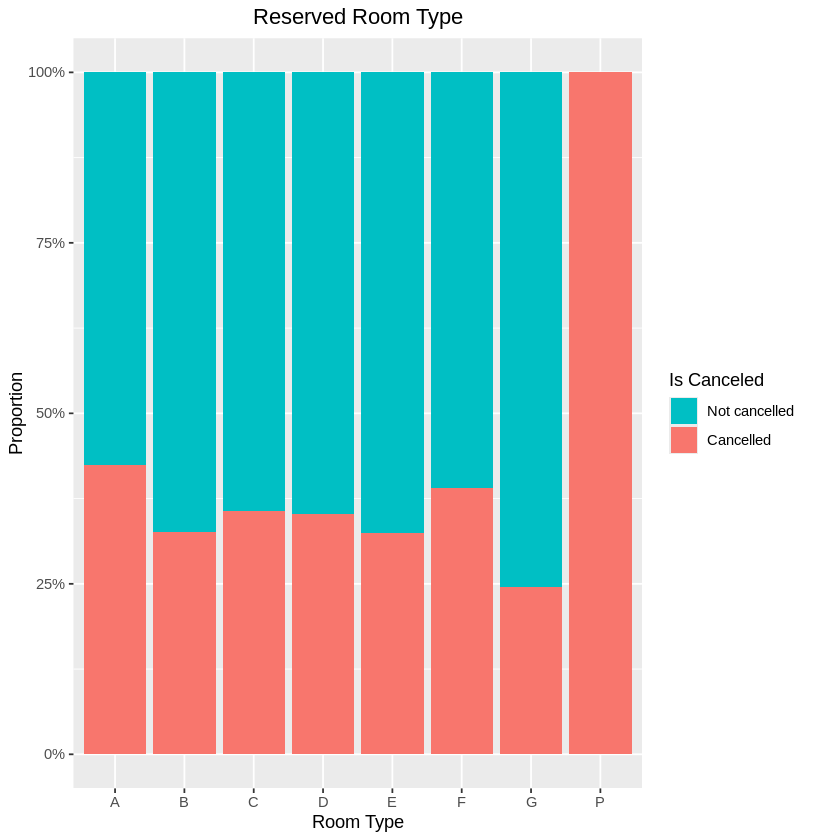

In [192]:
ggplot(data = bookings, aes(x = factor(reserved_room_type), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Reserved Room Type", x = "Room Type", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent) +
  scale_fill_manual(values = my_colors) +
  theme(plot.title = element_text(hjust = 0.5))

In [193]:
#Parking Spaces - Not significant
sum(bookings$reserved_room_type == "P")

[1] 10

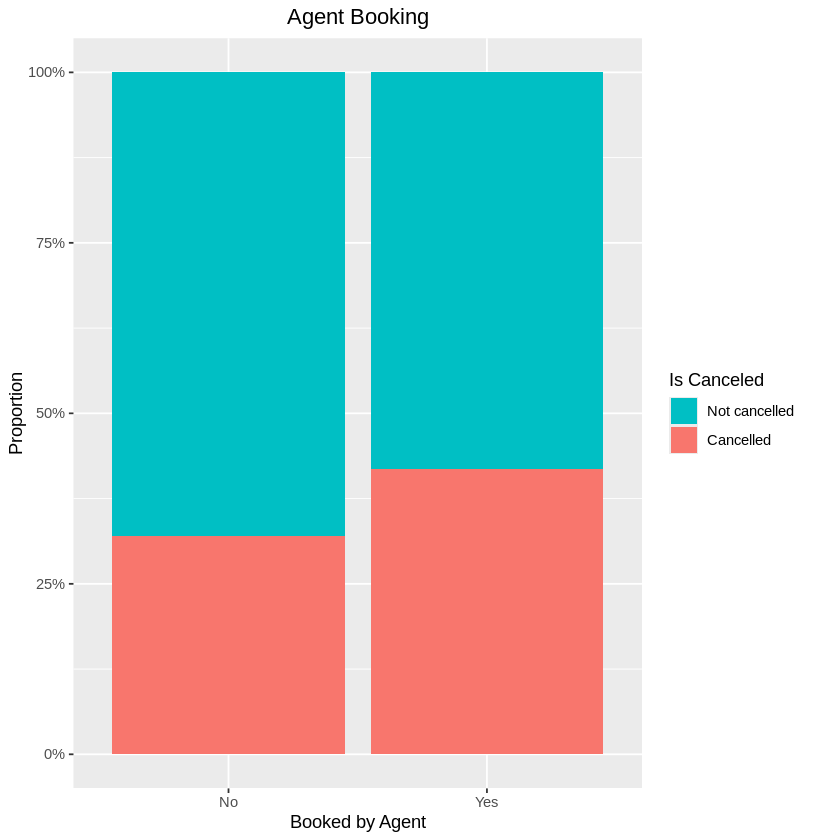

In [194]:
ggplot(data = bookings, aes(x = factor(booked_by_agent), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Agent Booking", x = "Booked by Agent", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

In [195]:
sum(bookings$booked_by_agent=="No")

[1] 8125

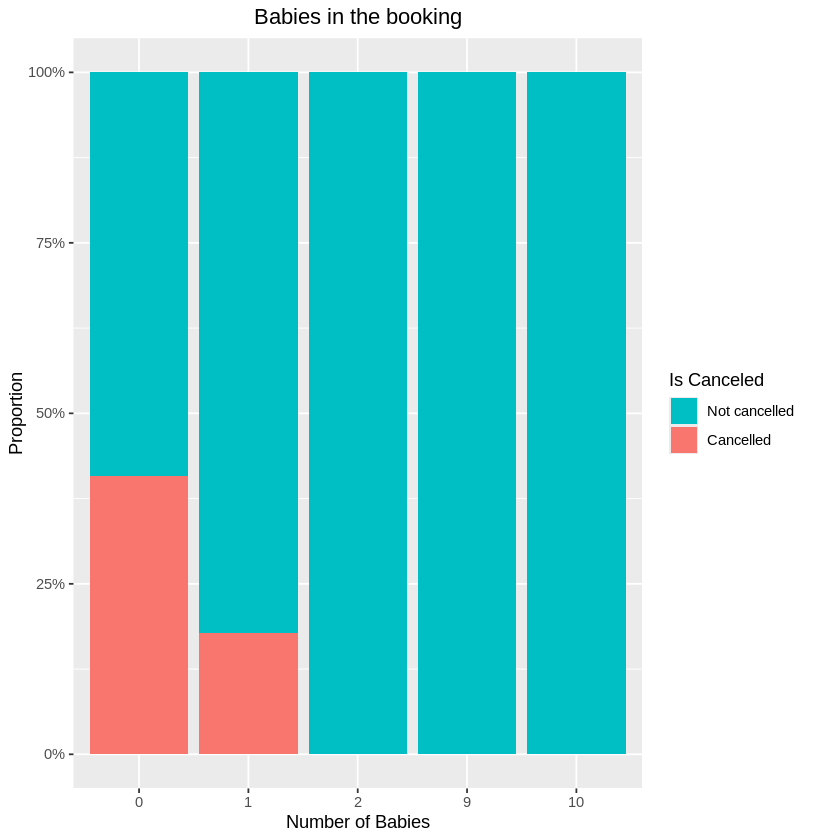

In [196]:
ggplot(data = bookings, aes(x = factor(babies), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Babies in the booking",x = "Number of Babies", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

In [197]:
sum(bookings$babies!=0)

[1] 369

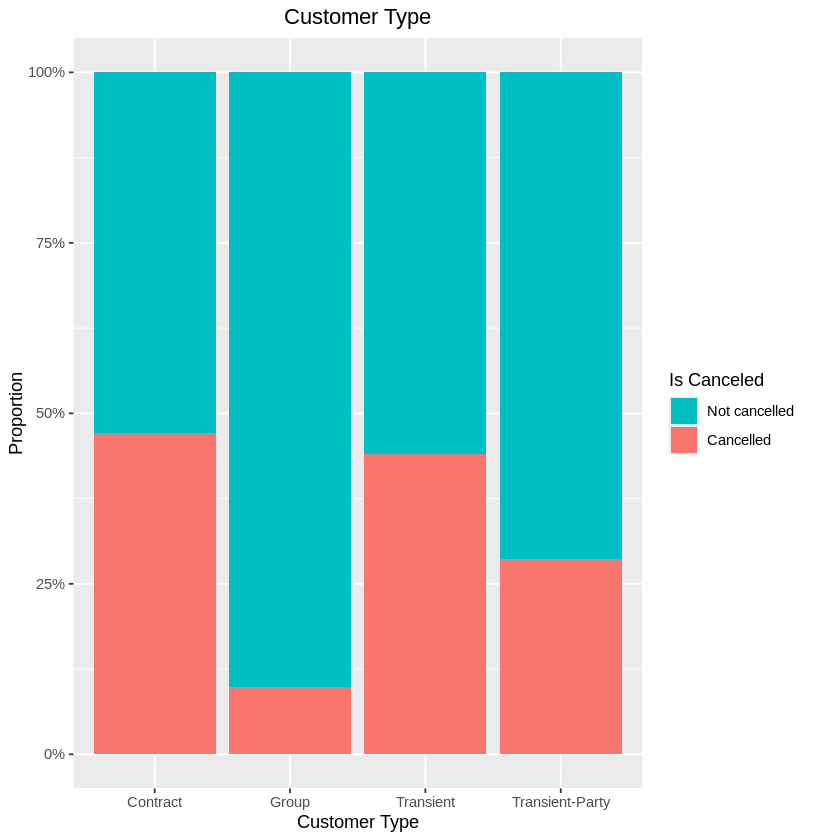

In [198]:
ggplot(data = bookings, aes(x = factor(customer_type), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Customer Type",x = "Customer Type", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

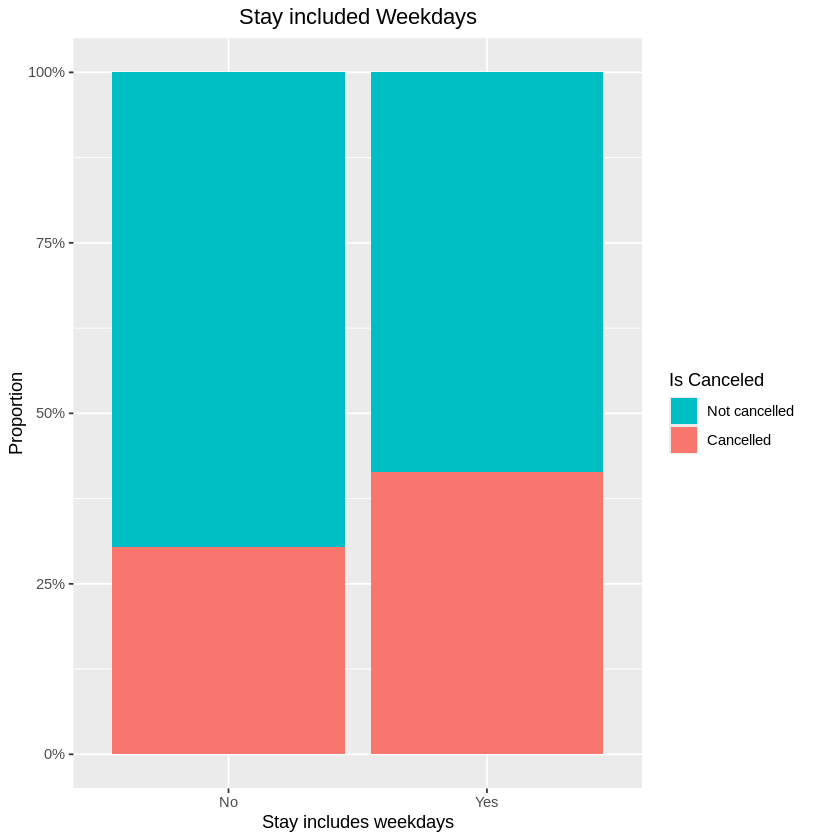

In [199]:
ggplot(data = bookings, aes(x = factor(includes_weekdays), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Stay included Weekdays",x = "Stay includes weekdays", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

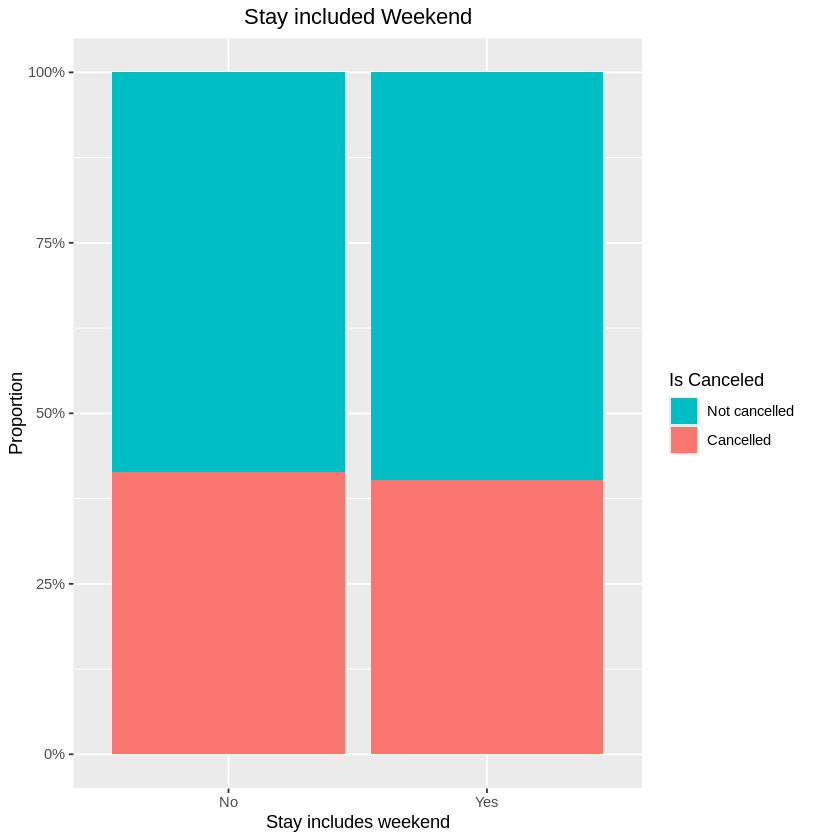

In [200]:
ggplot(data = bookings, aes(x = factor(includes_weekend), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Stay included Weekend",x = "Stay includes weekend", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

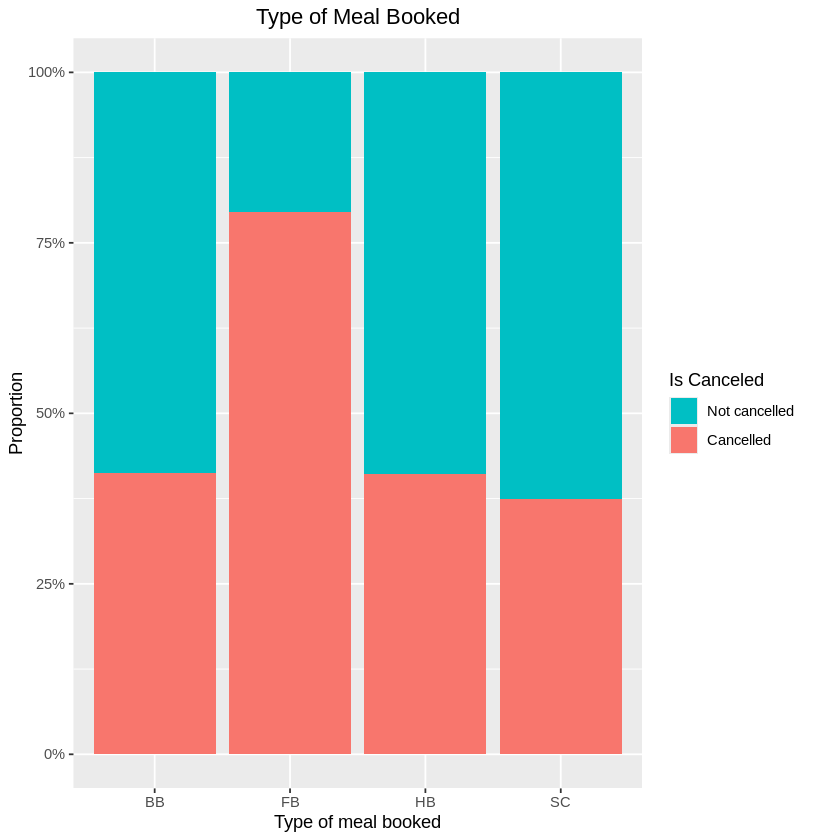

In [201]:
ggplot(data = bookings, aes(x = factor(meal), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Type of Meal Booked",x = "Type of meal booked", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

In [202]:
sum(bookings$meal=="FB")

[1] 44

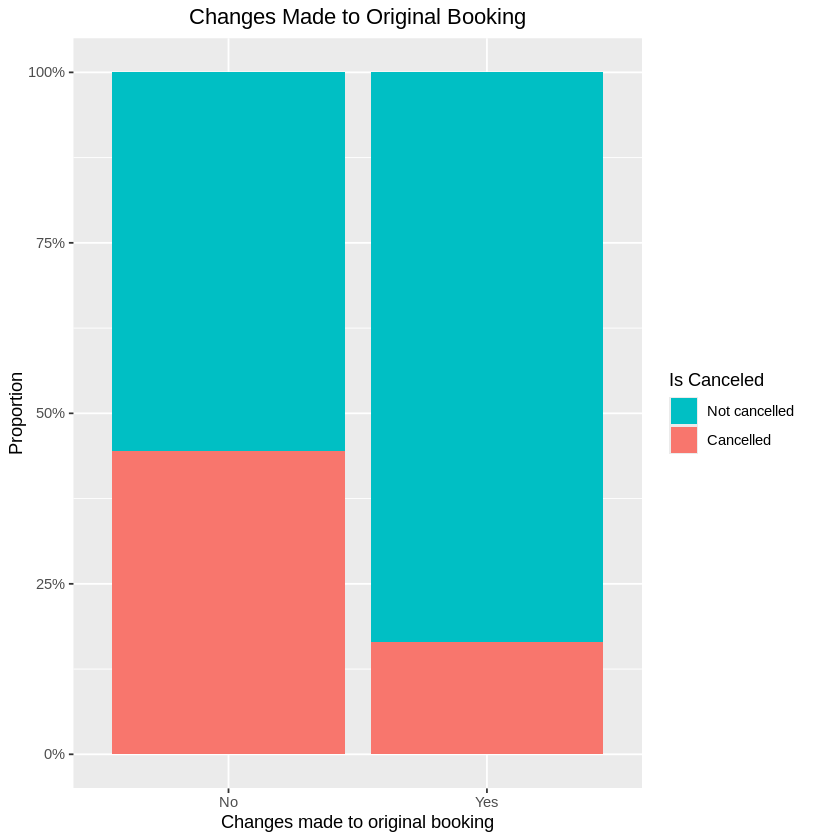

In [203]:
ggplot(data = bookings, aes(x = factor(changes_to_booking), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Changes Made to Original Booking",x = "Changes made to original booking", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

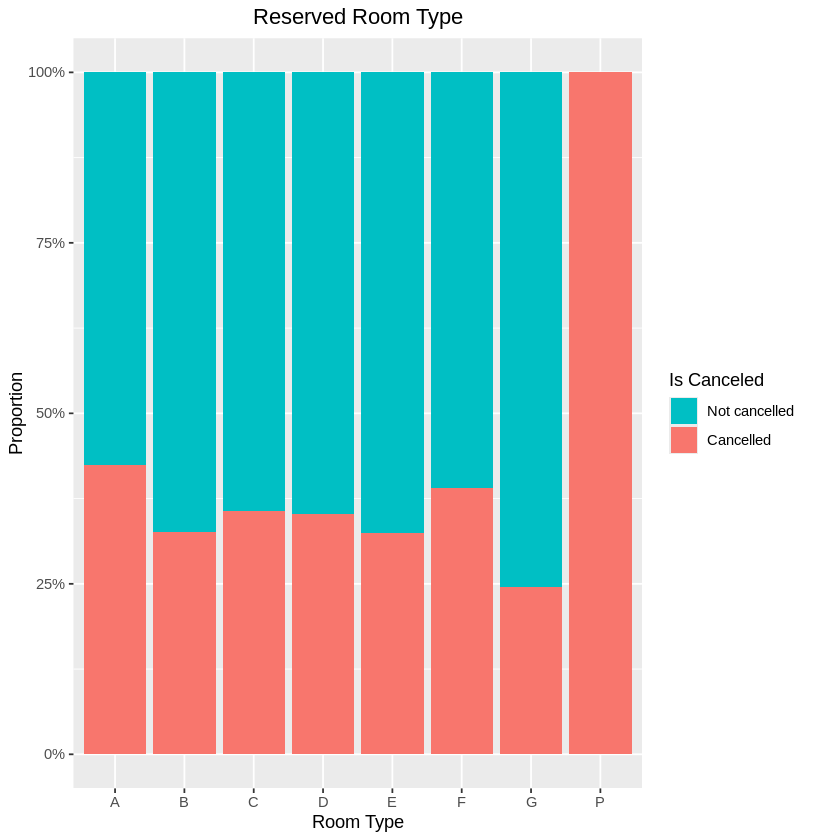

In [204]:
ggplot(data = bookings, aes(x = factor(reserved_room_type), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Reserved Room Type",x = "Room Type", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

In [205]:
#Room type - Not significant
sum(bookings$reserved_room_type == "P")

[1] 10

In [206]:
#Room type - Not significant
sum(bookings$reserved_room_type == "E")

[1] 1553

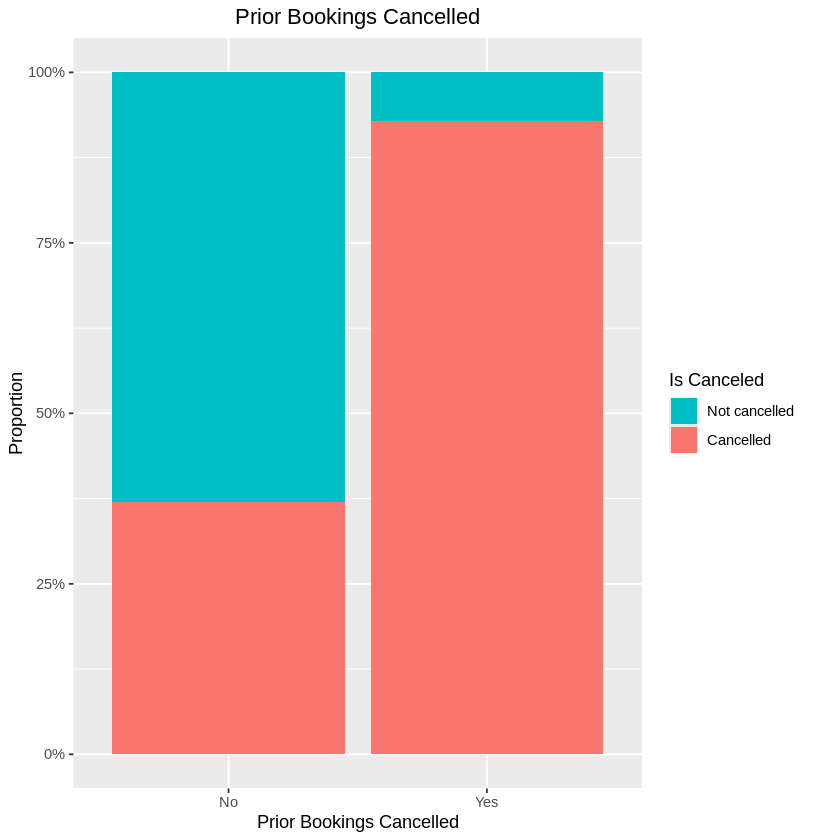

In [207]:
ggplot(data = bookings, aes(x = factor(prior_bookings_cancelled), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Prior Bookings Cancelled",x = "Prior Bookings Cancelled", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

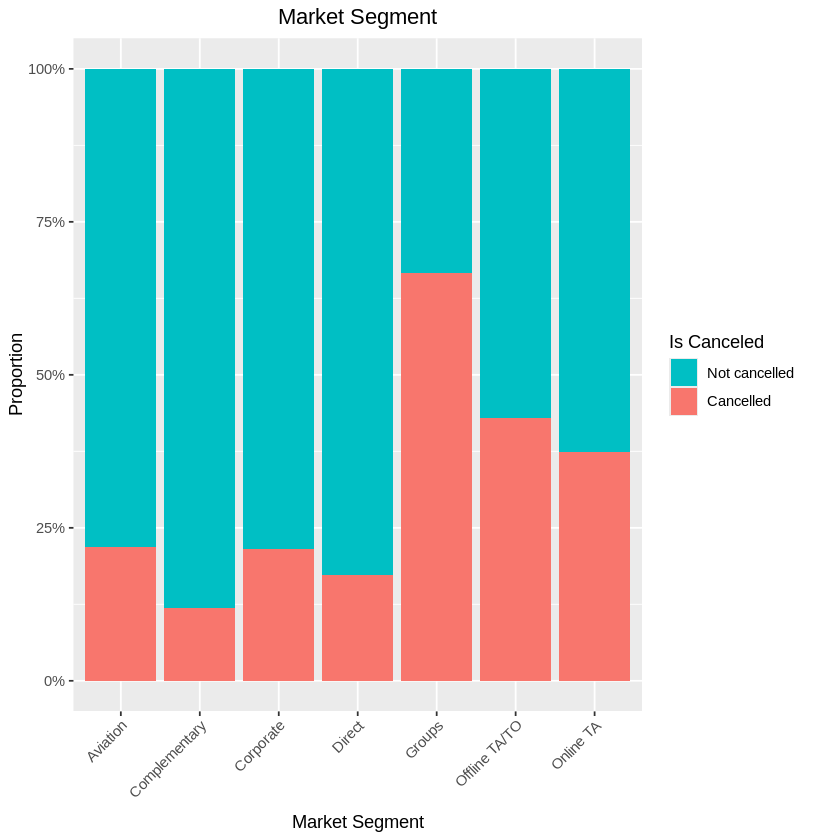

In [208]:
ggplot(data = bookings, aes(x = factor(market_segment), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Market Segment", x = "Market Segment", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent) +
  scale_fill_manual(values = my_colors) +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(angle = 45, hjust = 1) # Rotate labels by 45 degrees
  )

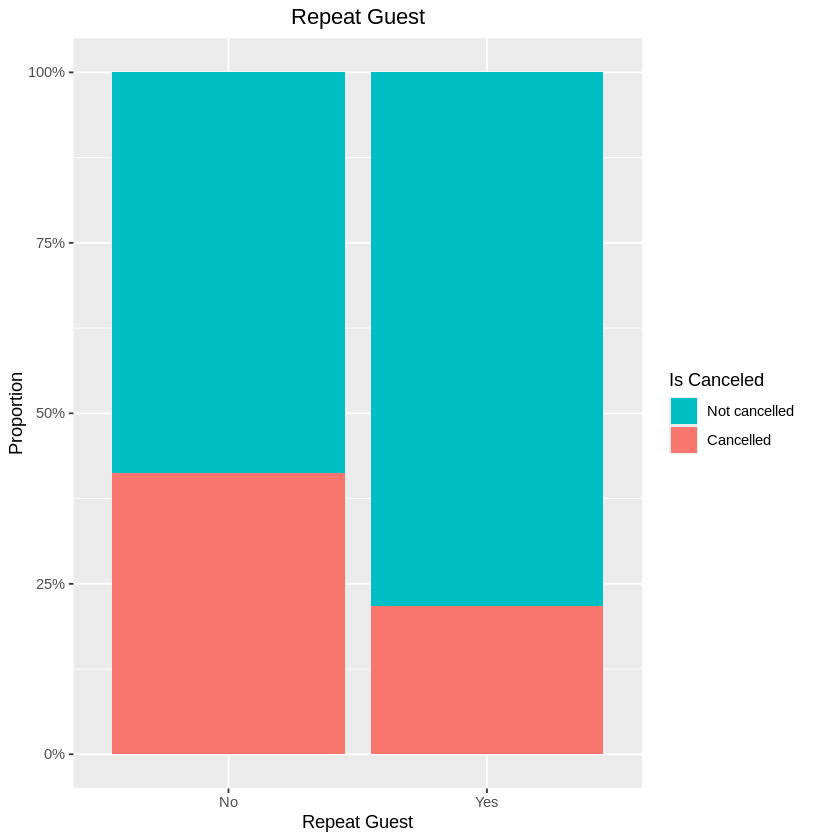

In [209]:
ggplot(data = bookings, aes(x = factor(is_repeated_guest), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(
    title = "Repeat Guest",
    x = "Repeat Guest",
    y = "Proportion",
    fill = "Is Canceled"
  ) +
  scale_y_continuous(labels = scales::percent) +
  scale_x_discrete(labels = c("No", "Yes")) + # Add this line
  scale_fill_manual(values = my_colors) +
  theme(plot.title = element_text(hjust = 0.5))

In [210]:
#Repeated Guest - Not significant
sum(bookings$is_repeated_guest==1)

[1] 2032

In [211]:
#Parking Spaces - Not significant
sum(bookings$required_car_parking_spaces!=0)

[1] 1925

In [212]:
#Special requests - Signficant
sum(bookings$total_of_special_requests!=0)

[1] 30777

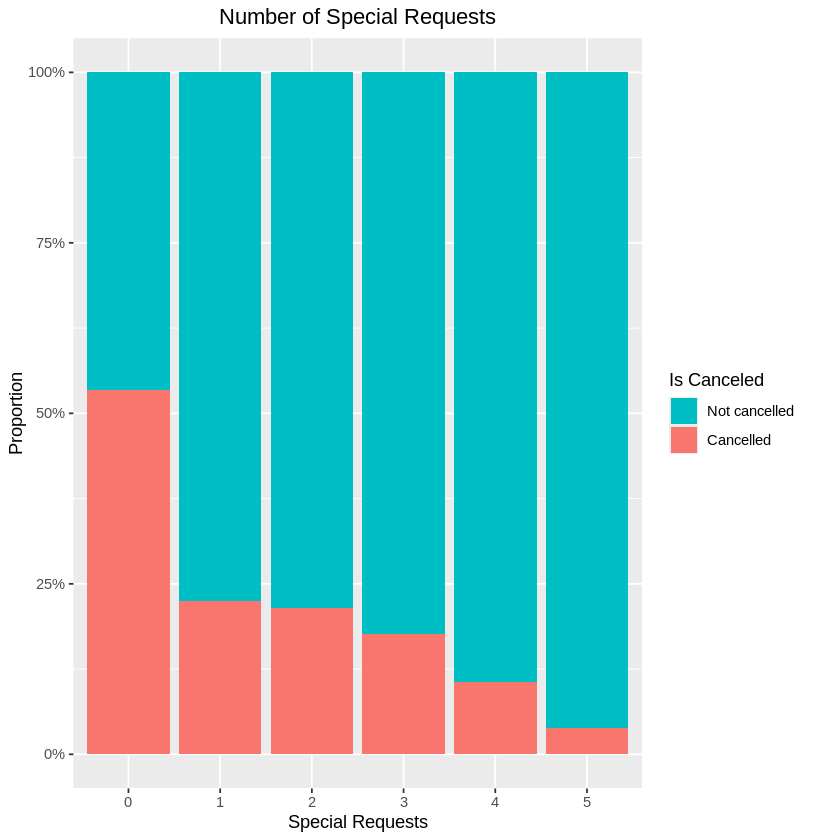

In [213]:
ggplot(data = bookings, aes(x = factor(total_of_special_requests), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Number of Special Requests",x = "Special Requests", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent)+
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

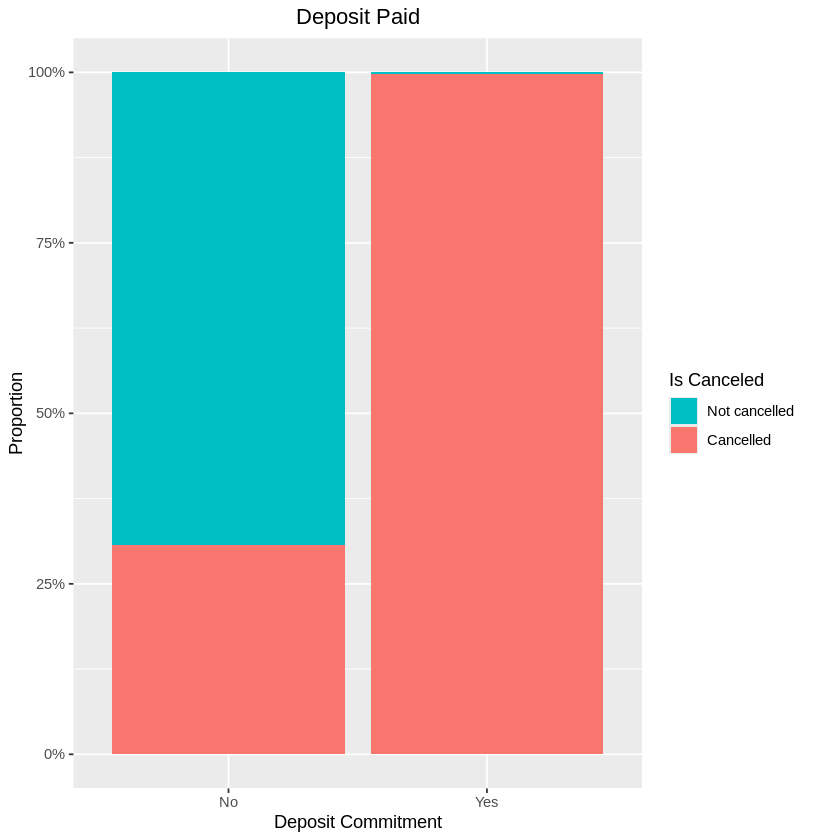

In [214]:
ggplot(data = bookings, aes(x = factor(deposit_commitment), fill = is_canceled)) +
  geom_bar(position = "fill") +
  labs(title = "Deposit Paid", x = "Deposit Commitment", y = "Proportion", fill = "Is Canceled") +
  scale_y_continuous(labels = scales::percent) +
  scale_fill_manual(values = my_colors)+
  theme(plot.title = element_text(hjust = 0.5))

# Dimension Reduction

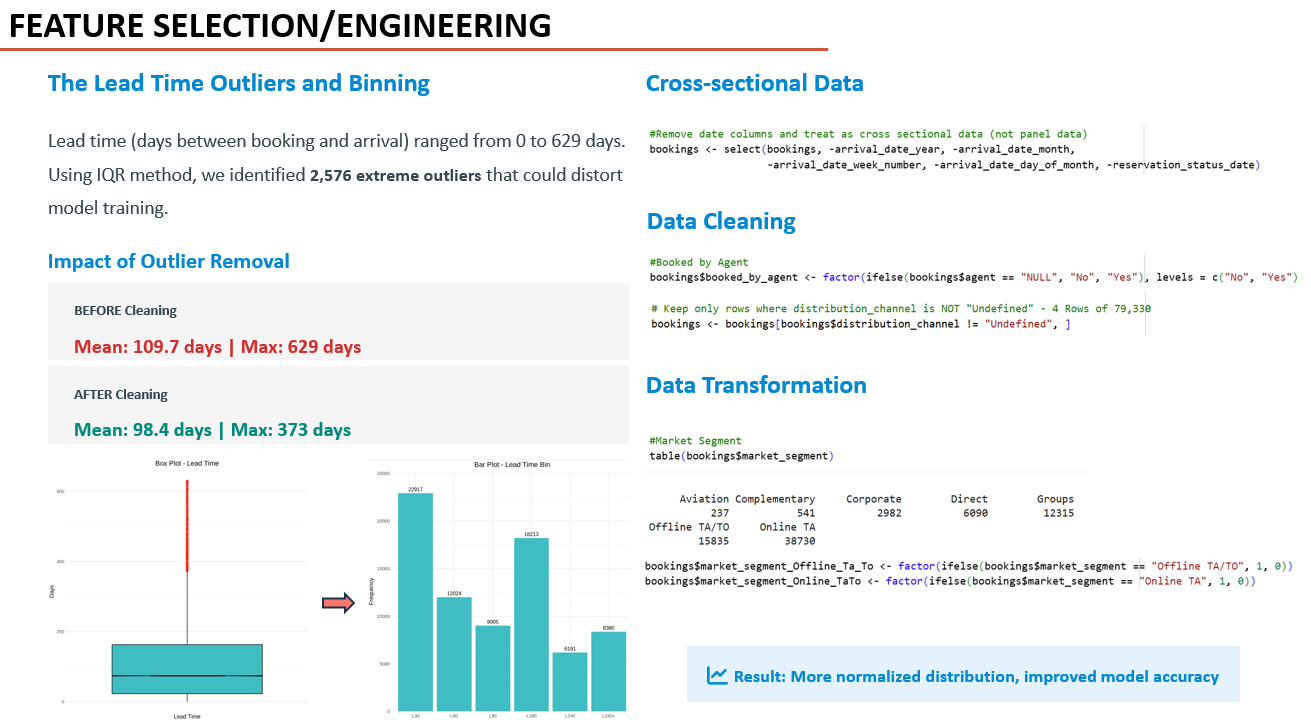

In [215]:
# Reservation status is not a predictor of cancellation
bookings <- select(bookings, -reservation_status)

In [216]:
# Agent code - we added a new column Booked by Agent
bookings <- select(bookings, -agent)

In [217]:
# Lead time - we added a new bin column for lead time
bookings <- select(bookings, -lead_time)

In [218]:
# Lead time - we added a new bin column for Previous cancellations
bookings <- select(bookings, -previous_bookings_not_canceled)
bookings <- select(bookings, -previous_cancellations)

In [219]:
bookings <- select(bookings, -stays_in_week_nights)
bookings <- select(bookings, -stays_in_weekend_nights)

In [220]:
bookings <- select(bookings, -booking_changes)

In [221]:
#bookings <- select(bookings, -required_car_parking_spaces)

In [222]:
bookings <- select(bookings, -company)

In [223]:
bookings <- select(bookings, -deposit_type)

In [224]:
bookings <- select(bookings, -market_segment)

In [225]:
bookings <- select(bookings, -assigned_room_type)

In [226]:
bookings <- select(bookings, -country)

In [227]:
bookings <- select(bookings, -adr)

In [228]:
#bookings <- select(bookings, -is_repeated_guest)

In [229]:
#Count rows and columns
nrow(bookings);ncol(bookings)

[1] 76730

[1] 27

In [230]:
colnames(bookings)

[1] "is_canceled"                  "adults"                      
 [3] "children"                     "babies"                      
 [5] "meal"                         "distribution_channel"        
 [7] "is_repeated_guest"            "reserved_room_type"          
 [9] "days_in_waiting_list"         "customer_type"               
[11] "required_car_parking_spaces"  "total_of_special_requests"   
[13] "lead_time_bin"                "booked_by_agent"             
[15] "prior_bookings_cancelled"     "prior_bookings_not_cancelled"
[17] "includes_weekend"             "includes_weekdays"           
[19] "changes_to_booking"           "deposit_commitment"          
[21] "market_segment_Offline_Ta_To" "market_segment_Online_TaTo"  
[23] "market_segment_Groups"        "market_segment_Complementary"
[25] "market_segment_Direct"        "market_segment_Corporate"    
[27] "market_segment_Aviation"

**Export bookings.csv**

In [231]:
write.csv(bookings, file = "/content/bookings.csv", row.names = FALSE)

In [232]:
# 1. Select only the numeric columns from the 'bookings' data frame
numeric_df <- bookings[, sapply(bookings, is.numeric)]

# 2. Calculate statistics and round the final matrix to 3 decimal places
results_rounded <- round(
  sapply(numeric_df, function(x) {
    c(
      Mean = mean(x, na.rm = TRUE),
      Std = sd(x, na.rm = TRUE),
      Min = min(x, na.rm = TRUE),
      Max = max(x, na.rm = TRUE)
    )
  }),
  digits = 3 # Specify the number of decimal places here
)

# Print the final result
print(results_rounded)


     adults children babies is_repeated_guest days_in_waiting_list
Mean  1.849    0.094  0.005             0.026                2.773
Std   0.515    0.378  0.086             0.161               16.574
Min   0.000    0.000  0.000             0.000                0.000
Max   4.000    3.000 10.000             1.000              259.000
     required_car_parking_spaces total_of_special_requests
Mean                       0.025                     0.557
Std                        0.157                     0.787
Min                        0.000                     0.000
Max                        3.000                     5.000


In [233]:
# Use the data frame containing only factor columns
factor_columns_df <- bookings[, sapply(bookings, is.factor)]

results_binary_stats <- round(
  sapply(factor_columns_df, function(col) {

    # --- CRITICAL STEP: Map specific strings to 0/1 ---
    # This assumes your factors are character strings "Yes" and "No".
    if(all(levels(col) %in% c("Yes", "No", NA))) {
        numeric_values <- as.numeric(ifelse(col == "Yes", 1, 0))
    } else {
        # If the factor levels are something else, use the default codes (1, 2, 3...)
        # You might want to handle this case differently depending on your data
        numeric_values <- as.numeric(col) - 1 # Subtract 1 to make range 0 to N-1
    }
    # --------------------------------------------------

    # Calculate statistics on the 0/1 numeric codes
    c(
      Mean = mean(numeric_values, na.rm = TRUE),
      Std = sd(numeric_values, na.rm = TRUE),
      Min = min(numeric_values, na.rm = TRUE),
      Max = max(numeric_values, na.rm = TRUE)
    )
  }),
  digits = 3
)

# Print the final result
print(results_binary_stats)

     is_canceled lead_time_bin booked_by_agent prior_bookings_cancelled
Mean       0.408         1.972           0.894                    0.068
Std        0.491         1.701           0.308                    0.252
Min        0.000         0.000           0.000                    0.000
Max        1.000         5.000           1.000                    1.000
     prior_bookings_not_cancelled includes_weekend includes_weekdays
Mean                        0.021            0.530             0.937
Std                         0.142            0.499             0.243
Min                         0.000            0.000             0.000
Max                         1.000            1.000             1.000
     changes_to_booking deposit_commitment market_segment_Offline_Ta_To
Mean              0.131              0.146                        0.206
Std               0.337              0.354                        0.405
Min               0.000              0.000                        0.000
Max    

# Classification - Decision Tree

**Step 1 - Install rpart and rplot packages**

In [234]:
#Load packages
library(rpart)
library(rpart.plot)

**Step 2 - Set up test/training data**

In [235]:
#Set seed for reproducibility
set.seed(123)


#Split data into training and testing data and create new dfs
train = sample(1:nrow(bookings),nrow(bookings)* 2/3)


bookings.train = bookings[train,]
bookings.test = bookings[-train,]

**Step 3 - Create decision tree**




In [236]:
#Determine paramenters for the tree
#xval = 0 and minsplit is arbirarily determined - we can change this later depending on how the initial tree looks
fit = rpart(is_canceled ~ .,
           data = bookings.train,
           method = "class",
           control = rpart.control(xval = 5,minsplit= 500),
           parms = list(split="gini"))
fit


n= 51153 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 51153 20891 Not cancelled (0.591597756 0.408402244)  
   2) deposit_commitment=No 43656 13413 Not cancelled (0.692757009 0.307242991)  
     4) prior_bookings_cancelled=No 42224 12248 Not cancelled (0.709928003 0.290071997)  
       8) market_segment_Online_TaTo=0 16676  2859 Not cancelled (0.828556009 0.171443991) *
       9) market_segment_Online_TaTo=1 25548  9389 Not cancelled (0.632495694 0.367504306)  
        18) total_of_special_requests>=0.5 15681  3888 Not cancelled (0.752056629 0.247943371) *
        19) total_of_special_requests< 0.5 9867  4366 Cancelled (0.442485051 0.557514949)  
          38) lead_time_bin=L30 3028  1123 Not cancelled (0.629128137 0.370871863) *
          39) lead_time_bin=L60,L90,L180,L240,L240+ 6839  2461 Cancelled (0.359847931 0.640152069)  
            78) customer_type=Contract,Group,Transient-Party 434    86 Not cancelled (0.801843318 0.198156682) *
            

deposit_commitment     prior_bookings_cancelled 
                6096.3342033                 1252.6628987 
   total_of_special_requests   market_segment_Online_TaTo 
                1160.7912685                  775.7089558 
               customer_type         days_in_waiting_list 
                 508.5616434                  336.6523089 
market_segment_Offline_Ta_To                lead_time_bin 
                 335.8490442                  304.3702528 
        distribution_channel        market_segment_Direct 
                 297.9318398                  186.7636998 
             booked_by_agent        market_segment_Groups 
                 177.8079456                  176.4578528 
                      adults            includes_weekdays 
                   7.9409676                    4.9254103 
prior_bookings_not_cancelled 
                   0.4171949

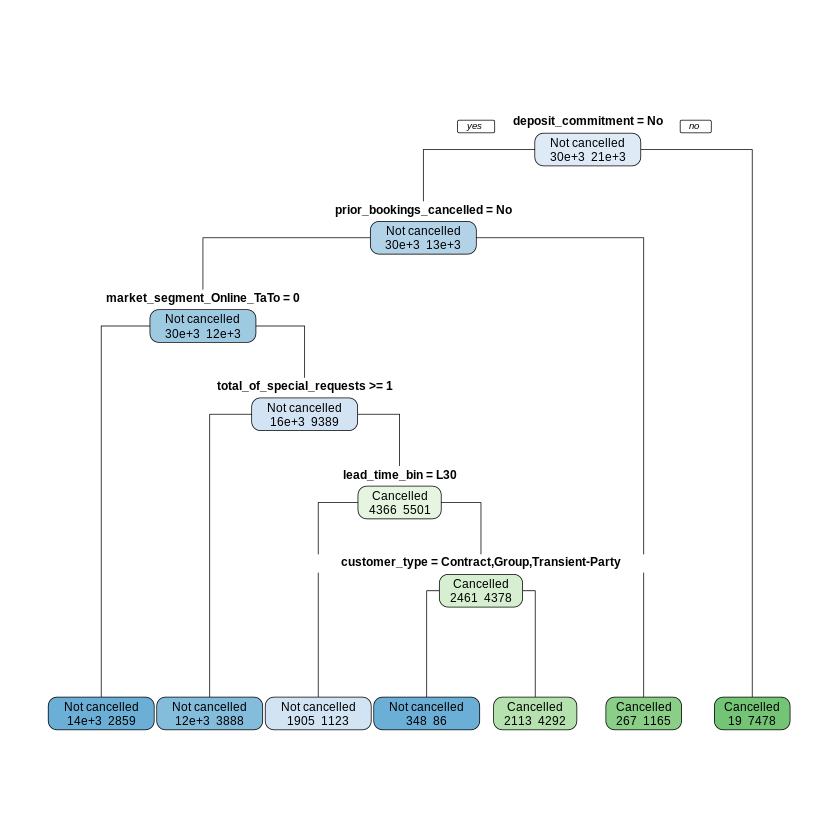

In [237]:
# make tree based on raw data
rpart.plot(fit,type = 1, extra = 1)
fit$variable.importance

**Step 4 - Refining Tree**

In [238]:
#Rerun same tree
fit = rpart(is_canceled~. -deposit_commitment,
           data = bookings.train,
           method = "class",
           control = rpart.control(xval = 5, minsplit = 500),
           parms = list(split="gini"))
fit


n= 51153 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 51153 20891 Not cancelled (0.59159776 0.40840224)  
   2) total_of_special_requests>=0.5 20582  4516 Not cancelled (0.78058498 0.21941502) *
   3) total_of_special_requests< 0.5 30571 14196 Cancelled (0.46436165 0.53563835)  
     6) lead_time_bin=L30 8268  2265 Not cancelled (0.72605225 0.27394775) *
     7) lead_time_bin=L60,L90,L180,L240,L240+ 22303  8193 Cancelled (0.36734968 0.63265032)  
      14) customer_type=Group,Transient-Party 6485  2571 Not cancelled (0.60354665 0.39645335)  
        28) prior_bookings_cancelled=No 5431  1520 Not cancelled (0.72012521 0.27987479) *
        29) prior_bookings_cancelled=Yes 1054     3 Cancelled (0.00284630 0.99715370) *
      15) customer_type=Contract,Transient 15818  4279 Cancelled (0.27051460 0.72948540)  
        30) market_segment_Groups=No 11913  4219 Cancelled (0.35415093 0.64584907)  
          60) distribution_channel=Direct,GDS 862   219 Not can

total_of_special_requests                lead_time_bin 
                 2460.049882                  1705.856574 
               customer_type     prior_bookings_cancelled 
                 1086.276238                   976.216042 
  market_segment_Online_TaTo        market_segment_Groups 
                  708.062166                   675.105339 
        distribution_channel        market_segment_Direct 
                  550.021623                   382.820056 
           is_repeated_guest                         meal 
                  194.043247                   181.904646 
             booked_by_agent           reserved_room_type 
                  167.684287                   134.455258 
    market_segment_Corporate                     children 
                  113.393860                    85.496535 
                      adults           changes_to_booking 
                   67.650774                    57.108000 
        days_in_waiting_list market_segment_Complementary 
                   24.070314                     1.985659

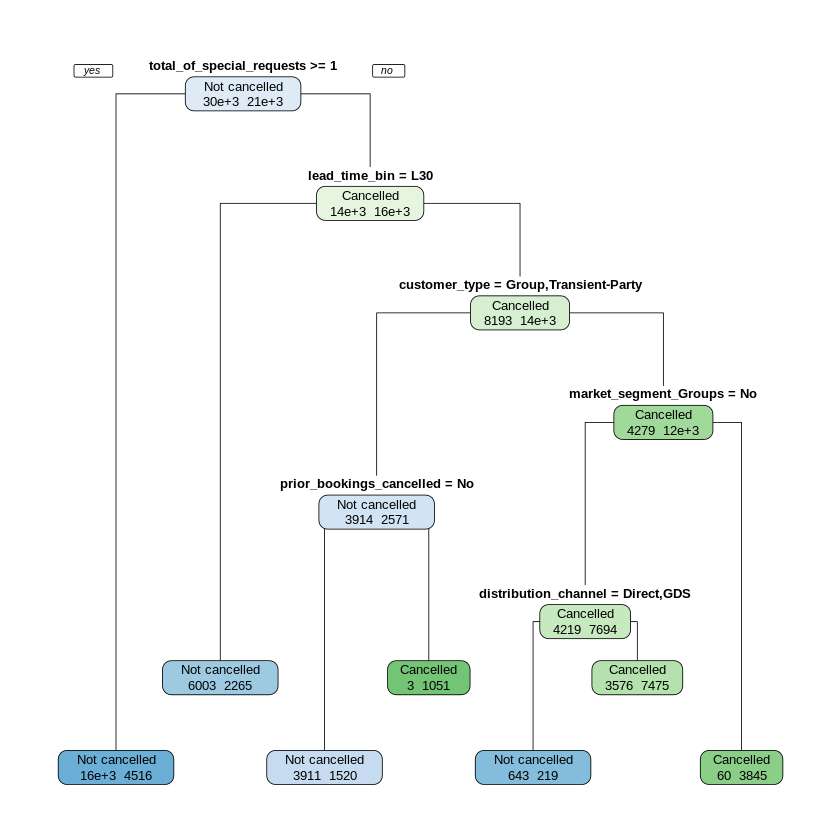

In [239]:
rpart.plot(fit,type = 1, tweak=0.8,extra = 1)
fit$variable.importance

In [240]:
fit$variable.importance

total_of_special_requests                lead_time_bin 
                 2460.049882                  1705.856574 
               customer_type     prior_bookings_cancelled 
                 1086.276238                   976.216042 
  market_segment_Online_TaTo        market_segment_Groups 
                  708.062166                   675.105339 
        distribution_channel        market_segment_Direct 
                  550.021623                   382.820056 
           is_repeated_guest                         meal 
                  194.043247                   181.904646 
             booked_by_agent           reserved_room_type 
                  167.684287                   134.455258 
    market_segment_Corporate                     children 
                  113.393860                    85.496535 
                      adults           changes_to_booking 
                   67.650774                    57.108000 
        days_in_waiting_list market_segment_Complementary 
                   24.070314                     1.985659

**Step 6 - Run Test**

In [241]:
#Extract vector of predicted class
bookings.pred <- predict(fit,bookings.train,type="class")
bookings.actual <- bookings.train$is_canceled

In [242]:
#Build confusion matrix
confusion_matrix <- table(bookings.pred,bookings.actual)
confusion_matrix

               bookings.actual
bookings.pred   Not cancelled Cancelled
  Not cancelled         26623      8520
  Cancelled              3639     12371

In [243]:
#Check accuracy on training data
proportion <- prop.table(confusion_matrix)
proportion
addmargins(proportion)
proportion[1,1] + proportion[2,2]

               bookings.actual
bookings.pred   Not cancelled  Cancelled
  Not cancelled    0.52045823 0.16655915
  Cancelled        0.07113952 0.24184310

,Not cancelled,Cancelled,Sum
Not cancelled,0.52045823,0.1665591,0.6870174
Cancelled,0.07113952,0.2418431,0.3129826
Sum,0.59159776,0.4084022,1.0000000


[1] 0.7623013

In [244]:
#Accuracy on testing data
bookings.pred.test <- predict(fit,bookings.test,type="class")
bookings.actual.test <- bookings.test$is_canceled

confusion_matrix_test <- table(bookings.pred.test,bookings.actual.test)
confusion_matrix_test


                  bookings.actual.test
bookings.pred.test Not cancelled Cancelled
     Not cancelled         13389      4263
     Cancelled              1799      6126

In [245]:
pt <- prop.table(confusion_matrix_test)
pt
addmargins(pt)
pt[1,1] + pt[2,2]

                  bookings.actual.test
bookings.pred.test Not cancelled  Cancelled
     Not cancelled    0.52347812 0.16667318
     Cancelled        0.07033663 0.23951206

,Not cancelled,Cancelled,Sum
Not cancelled,0.52347812,0.1666732,0.6901513
Cancelled,0.07033663,0.2395121,0.3098487
Sum,0.59381476,0.4061852,1.0000000


[1] 0.7629902

**Step 7 - Calculate Errors**

In [246]:
#Errors for training data
tp_train = 12371
tn_train = 26623
fp_train = 3639
fn_train = 8520

accuracy_train = (tp_train+tn_train) / (tp_train + tn_train + fp_train + fn_train)
print(accuracy_train)

error_rate_train = 1 - accuracy_train
print(error_rate_train)

tpr_train = tp_train / (tp_train + fn_train)
print(tpr_train)

tnr_train = tn_train / (tn_train + fp_train)
print(tnr_train)

fpr_train = 1 - tnr_train
print(tnr_train)

fnr_train = 1 - tpr_train
print(fnr_train)



[1] 0.7623013
[1] 0.2376987
[1] 0.5921689
[1] 0.8797502
[1] 0.8797502
[1] 0.4078311


In [247]:
#Errors for testing data
tp_test = 6126
tn_test = 13389
fp_test = 1799
fn_test = 4263

accuracy_test = (tp_test+tn_test) / (tp_test + tn_test + fp_test + fn_test)
print(accuracy_test)

error_rate_test = 1 - accuracy_test
print(error_rate_test)

tpr_test = tp_test / (tp_test + fn_test)
print(tpr_test)

tnr_test = tn_test / (tn_test + fp_test)
print(tnr_test)

fpr_test = 1 - tnr_test
print(fpr_test)

fnr_test = 1 - tpr_test
print(fnr_test)


[1] 0.7629902
[1] 0.2370098
[1] 0.5896621
[1] 0.8815512
[1] 0.1184488
[1] 0.4103379


# Classification - Logistic Regression



**Step 1**

Splitting the data into training and    test data

In [248]:

# 1. Split data
set.seed(2)
train <- sample(1:nrow(bookings), (0.6)*nrow(bookings))
bookings.train <- bookings[train,]
bookings.test <- bookings[-train,]



**Step 2**

 Logistic regression and
display the results

In [249]:
# --- STEP 2: LOGISTIC REGRESSION ---
# Run logistic regression with ONLY significant variables
logit.reg <- glm(is_canceled ~ prior_bookings_cancelled +
                               total_of_special_requests +
                               lead_time_bin +
                               market_segment_Offline_Ta_To +
                               market_segment_Online_TaTo +
                               market_segment_Groups +
                               market_segment_Complementary +
                               market_segment_Direct +
                               market_segment_Corporate +
                               market_segment_Aviation +
                               prior_bookings_not_cancelled +
                               customer_type +
                               distribution_channel +
                               is_repeated_guest +
                               required_car_parking_spaces,
                 data = bookings.train,
                 family = "binomial")

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


**Step 3**

 Interpretation of
significancy and coefficient

In [250]:
summary(logit.reg)


Call:
glm(formula = is_canceled ~ prior_bookings_cancelled + total_of_special_requests + 
    lead_time_bin + market_segment_Offline_Ta_To + market_segment_Online_TaTo + 
    market_segment_Groups + market_segment_Complementary + market_segment_Direct + 
    market_segment_Corporate + market_segment_Aviation + prior_bookings_not_cancelled + 
    customer_type + distribution_channel + is_repeated_guest + 
    required_car_parking_spaces, family = "binomial", data = bookings.train)

Coefficients: (1 not defined because of singularities)
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -1.34289    0.24158  -5.559 2.72e-08 ***
prior_bookings_cancelledYes       5.05917    0.18522  27.314  < 2e-16 ***
total_of_special_requests        -0.91824    0.01878 -48.883  < 2e-16 ***
lead_time_binL60                  0.78689    0.03602  21.844  < 2e-16 ***
lead_time_binL90                  0.83573    0.03957  21.119  < 2e-16 ***
lead_time_binL

**Step 4**

Accuracy on the
training & test data

In [251]:
 #i.e., the estimated probability of an observation being in class “1”
logitPredict <- predict(logit.reg, bookings.test, type = "response")

In [252]:
# Convert probability to a classification
# if probability > cutoff, then class = 1, otherwise class =0
logitPredictClass <- ifelse(logitPredict > 0.5, 1, 0)

In [253]:
#Confusion matrix
actual <- bookings.test$is_canceled
predict <- logitPredictClass
cm <- table(predict, actual)
print(cm)

       actual
predict Not cancelled Cancelled
      0         15751      4644
      1          2311      7986


In [254]:
# consider class "1" as positive
tp <- cm[2,2]
tn <- cm[1,1]
fp <- cm[2,1]
fn <- cm[1,2]

In [255]:
# Accuracy
accuracy <- (tp + tn) / (tp + tn + fp + fn)
print(accuracy)

[1] 0.7733937


In [256]:
# TPR = Recall = Sensitivity
tpr <- tp / (fn + tp)
print(tpr)

[1] 0.632304


In [257]:
# TNR = Specificity
tnr <- tn / (fp + tn)
print(tnr)

[1] 0.8720518


In [258]:
# FPR
fpr <- fp / (fp + tn)
print(fpr)

[1] 0.1279482


In [259]:
# FNR
fnr <- fn / (fn + tp)
print(fnr)

[1] 0.367696


# Model Performance

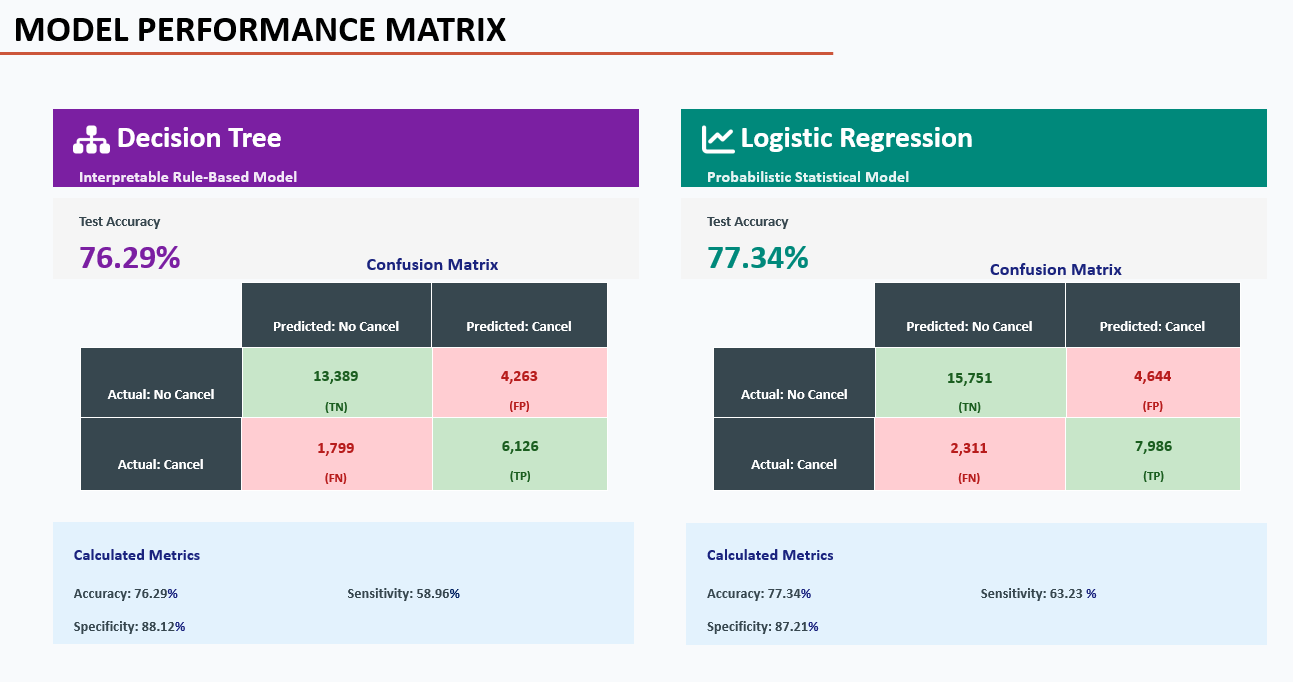

# Analysis Insights

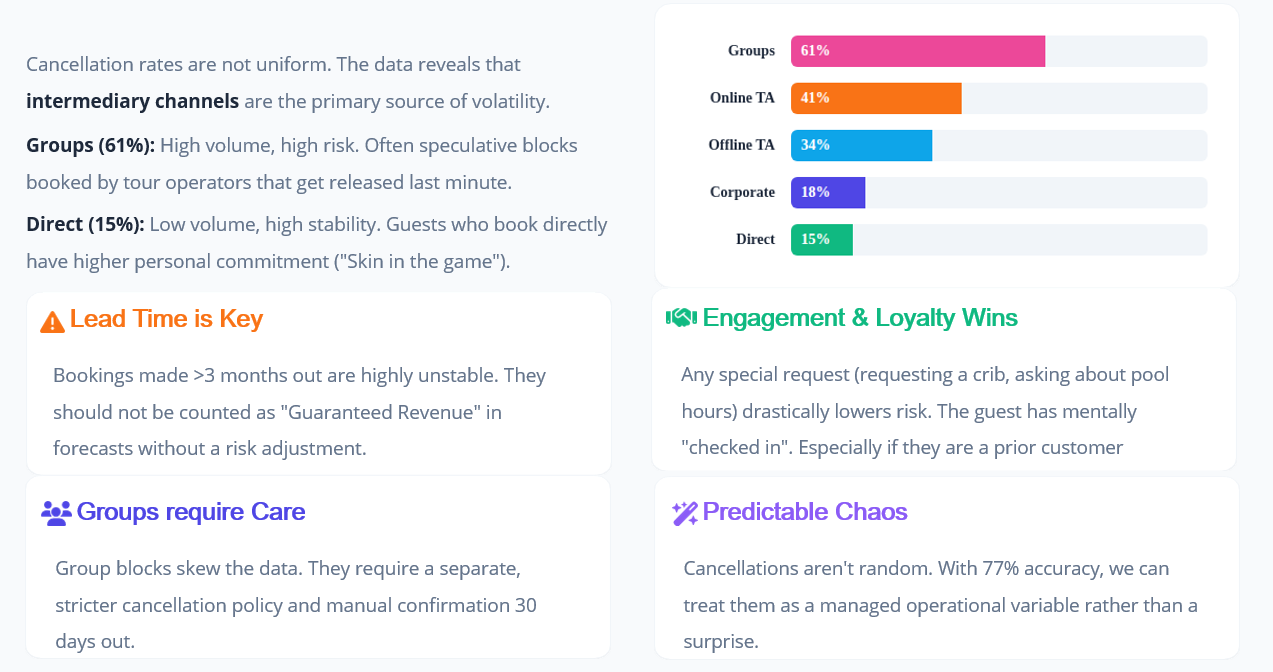